# Import Stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import math
import typing as tp

import arch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow
from recombinator import stationary_bootstrap
import scipy as sp
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.tsa.stattools import adfuller

from ovm.garch_estimation import estimate_garch_parameters

from ovm.historical_data_io import (
    PriceHistoryColumnNames as PHCN, 
    compute_scaling_factor, 
    compute_scaled_log_returns, 
    PriceHistory, 
    compute_number_of_days_in_price_history, 
    compute_log_returns_from_price_history, 
    save_price_histories, 
    load_price_history
)

from ovm.utils import TimeResolution

In [3]:
%matplotlib inline

# Set Parameters

If you want to estimate and simulate a different time scale, make changes here but keep in mind that you need to download the appropriate historical data first (see data import notebook).

In [4]:
time_resolution = TimeResolution.FIFTEEN_SECONDS
directory_path = time_resolution.value

In [5]:
price_history_file_name = 'ETH-USD'

# Load Price History

In [6]:
price_history = \
    load_price_history(filename=price_history_file_name, 
                       series_name=price_history_file_name, 
                       directory_path=directory_path, 
                       period_length_in_seconds=time_resolution.in_seconds)

In [7]:
path_length = len(price_history.price_history_df)

# Estimate GARCH Model

In [8]:
garch_estimation_result = estimate_garch_parameters(price_history)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 79129805.79060787
Iteration:      2,   Func. Count:     22,   Neg. LLF: 80888917.61945553
Iteration:      3,   Func. Count:     33,   Neg. LLF: 119768896.6174169
Iteration:      4,   Func. Count:     48,   Neg. LLF: 90686505.20289567
Iteration:      5,   Func. Count:     61,   Neg. LLF: 83119316.84795986
Iteration:      6,   Func. Count:     73,   Neg. LLF: 115634579.87095194
Iteration:      7,   Func. Count:     86,   Neg. LLF: 1735173.053234503
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1735173.0525404052
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 7


In [9]:
garch_estimation_result.result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      ETH-USD   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.73517e+06
Distribution:      Standardized Student's t   AIC:                       3.47036e+06
Method:                  Maximum Likelihood   BIC:                       3.47042e+06
                                              No. Observations:              2485980
Date:                      Mon, Dec 21 2020   Df Residuals:                  2485975
Time:                              20:40:13   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.9918e-06  1.559e-04  4.484e-02      0.964 [-2.986e-04,3.126e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  1.090e-04    158.707      0.000 [1.709e-02,1.752e-02]
alpha[1]       0.2000  9.372e-04    213.394      0.000     [  0.198,  0.202]
beta[1]        0.7800  8.571e-04    909.991      0.000     [  0.778,  0.782]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0216  6.907e-03    582.222      0.000 [  4.008,  4.035]
========================================================================

Covariance estimator: robust
"""

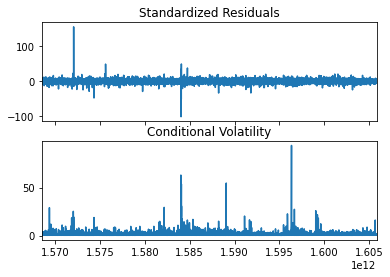

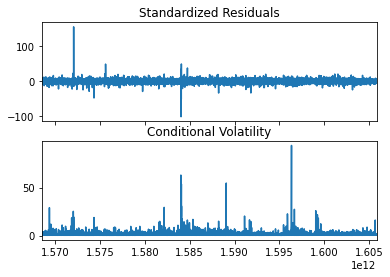

In [10]:
garch_estimation_result.result.plot()

# Simulate New Path Using GARCH

In [11]:
2# This is pretty slow. I intend to speed this up later on.
garch_simulation_result = \
    garch_estimation_result.simulate(path_length=path_length, 
                                     initial_discard_length=500)

In [12]:
garch_simulation_result.head()

0    0.000848
1    0.000119
2   -0.000083
3    0.001063
4   -0.000969
Name: data, dtype: float64

This is the simulated time series

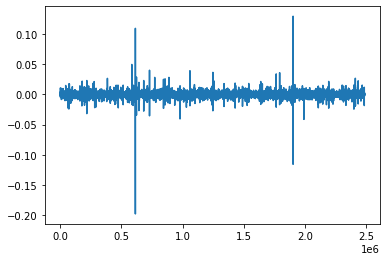

In [13]:
plt.plot(garch_simulation_result);

Note that the GARCH model succeeds at capturing average volatility during typical times but is unable to generate a few extreme returns.

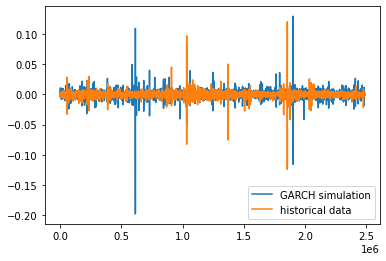

In [14]:
plt.plot(garch_simulation_result, label='GARCH simulation');
plt.plot(price_history.unscaled_log_returns.values, label='historical data');
plt.legend();

This model mis-specification arising from the T-distribution's inability to generate sufficiently heavy tails will be addressed by the non-parametric block-bootstrap.

This can be seen in the QQ-Plot (note the outliers at the extremes)

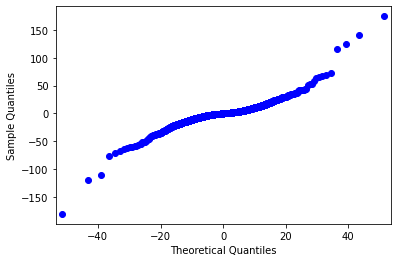

In [15]:
garch_estimation_result.qq_plot();

# Simulate New Path Using Block Bootstrap

Make the block size approximately 6 hours

In [16]:
# block_length = math.ceil(6 * 60 * 60 / time_resolution.in_seconds)
block_length = math.ceil(4 * 24 * 60 * 60 / time_resolution.in_seconds)
# block_length

In [17]:
bootstrap_simulation_result = \
    stationary_bootstrap(x=price_history.unscaled_log_returns, 
                         block_length=block_length, 
                         replications=1).squeeze()

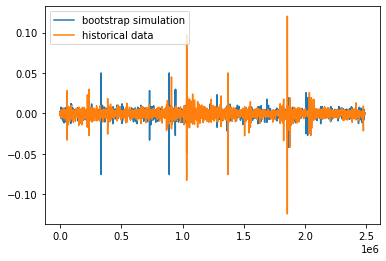

In [18]:
plt.plot(bootstrap_simulation_result, label='bootstrap simulation');
plt.plot(price_history.unscaled_log_returns.values, label='historical data');
plt.legend(loc=2);

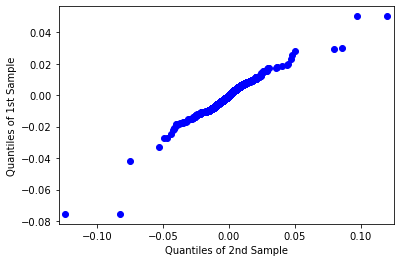

In [19]:
qqplot_2samples(bootstrap_simulation_result, price_history.unscaled_log_returns.values);

Estimate GARCH model with t-distributed errors from boostrap

In [20]:
garch_11_t = \
    arch.arch_model(compute_scaled_log_returns(bootstrap_simulation_result, 
                                               period_length_in_seconds=time_resolution.in_seconds), 
                    vol='garch', 
                    p=1, 
                    o=0, 
                    q=1, 
                    dist='StudentsT'
                   )
garch_11_t_fitted = garch_11_t.fit()
garch_11_t_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1640774349.4409616
Iteration:      2,   Func. Count:     22,   Neg. LLF: 549114253.5583324
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1556394.832464775
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1556394.831722133
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.55639e+06
Distribution:      Standardized Student's t   AIC:                       3.11280e+06
Method:                  Maximum Likelihood   BIC:                       3.11286e+06
                                              No. Observations:              2485980
Date:                      Mon, Dec 21 2020   Df Residuals:                  2485975
Time:                              20:41:03   Df Model:                            5
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -6.2113e-04  1.581e-04     -3.928  8.570e-05 [-9.311e-04,-3.112e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0100  5.722e-05    175.370      0.000 [9.923e-03,1.015e-02]
alpha[1]       0.1000  4.983e-04    200.676      0.000   [9.902e-02,  0.101]
beta[1]        0.8800  4.482e-04   1963.328      0.000     [  0.879,  0.881]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0249  5.765e-03    698.216      0.000 [  4.014,  4.036]
========================================================================

Covariance estimator: robust
"""

The GARCH volatility and distribution coefficients are close to those estimated from the original time series.